In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import seaborn as sns
from thesispy.definitions import ROOT_DIR

INSTANCES_PATH = Path('/home/joasiee/Documents/instances/synthetic/scans/')

In [75]:
def get_img_data(path: Path):
    image = sitk.ReadImage(str(path.resolve()))
    return sitk.GetArrayFromImage(image)

def get_cmap_color(cmap, f, a):
    c = cmap(f)
    c[..., 3] = a
    return c

def plot_voxels(data, y_slice_depth = 15, orientation=(0, -70), cmap_name='Greys', alpha=1.0):
    ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
    sliced_data = np.copy(data)
    sliced_data[:, :y_slice_depth, :] = 0
    
    cmap = cm.get_cmap(cmap_name)
    norm = Normalize(vmin=np.min(sliced_data), vmax=1.5*np.max(sliced_data))

    colors = np.array(list(map(lambda x: get_cmap_color(cmap, norm(x), alpha), sliced_data)))

    ax.voxels(sliced_data, facecolors=colors, edgecolor=(0, 0, 0, 0.2))
    ax.set_xlim3d(1, 29)
    ax.set_ylim3d(5, 29)
    ax.set_zlim3d(1, 29)
    ax.set_box_aspect((np.ptp(ax.get_xlim()), np.ptp(ax.get_ylim()), np.ptp(ax.get_zlim())))
    plt.locator_params(axis='y', nbins=3)
    ax.view_init(*orientation)

def plot_dvf(data, slice=15):
    X, Y = np.indices(data.shape[:2])
    u = data[:, slice, :, 0]
    v = data[:, slice, :, 2]
    colors = np.linalg.norm(data[:, slice, :, [0, 2]], axis=0) # np swaps smallest dim axis to 0
    
    fig, ax = plt.subplots(figsize =(8, 8))
    ax.quiver(X, Y, u, v, colors, angles='xy', scale_units='xy', cmap="Greys")
    plt.show()

In [25]:
from joblib import Parallel, delayed

def hessian(dvf_slice, p):
  p = np.array(p, dtype=int)
  try:
    dvf_slice[tuple(p)]
  except IndexError:
    print(f"Point {p} is out of bounds")
    return None

  n = len(p)
  output = np.matrix(np.zeros(n*n))
  output = output.reshape(n,n)
  max_indices = np.array(dvf_slice.shape) - 1
  
  for i in range(n):
    for j in range(i+1):
      ei = np.zeros(n, dtype=int)
      ei[i] = 1
      ej = np.zeros(n, dtype=int)
      ej[j] = 1
      f1 = dvf_slice[tuple((np.clip(p + ei + ej, 0, max_indices)))]
      f2 = dvf_slice[tuple((np.clip(p + ei - ej, 0, max_indices)))]
      f3 = dvf_slice[tuple((np.clip(p - ei + ej, 0, max_indices)))]
      f4 = dvf_slice[tuple((np.clip(p - ei - ej, 0, max_indices)))]
      numdiff = (f1-f2-f3+f4)/4     
      output[i,j] = numdiff
      output[j,i] = numdiff
  return output

def bending_energy_point(dvf, p):
  sum = 0.0
  for dim in range(len(dvf.shape)-1):
    sum += np.square(np.linalg.norm(hessian(dvf[..., dim], p)))
  return sum

def bending_energy(dvf):
  results = Parallel(n_jobs=16)(delayed(bending_energy_point)(dvf, p) for p in np.ndindex(dvf.shape[:-1]))

  return np.sum(results) / np.prod(dvf.shape[:-1])

In [41]:
data = get_img_data(ROOT_DIR / "output" / "1662841364_synthetic_1_adaptivestochasticgradientdescent_593078" / "out" / "result.mhd")

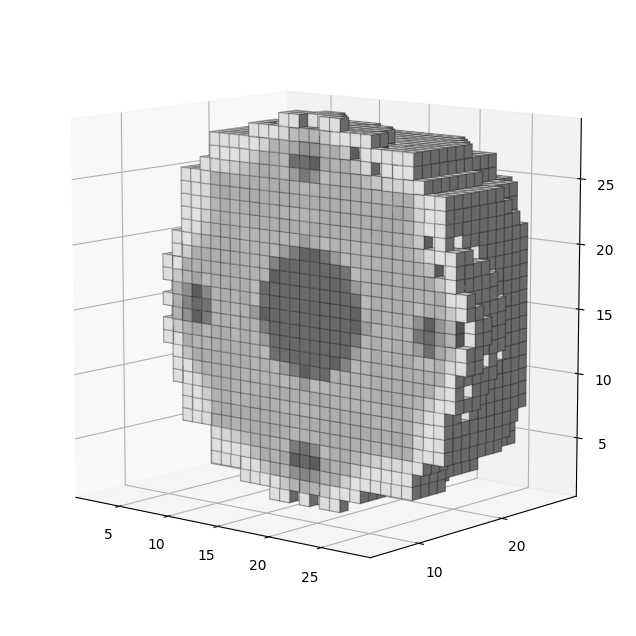

In [79]:
plot_voxels(data, orientation=(10, -50))

In [27]:
from joblib import Parallel, delayed
import numdifftools as nd
from interp3d import interp_3d

def get_hessians_numdiff(dvf):
  hessians = []
  for dim in range(len(dvf.shape)-1):
      dvf_slice = dvf[..., dim]
      max_indices = np.array(dvf_slice.shape) - 1
      dvf_mapping = lambda x: dvf_slice[tuple(np.clip(x.astype(int), 0, max_indices))]
      hessian = nd.Hessian(dvf_mapping, step=1)
      hessians.append(hessian)
  return hessians

def bending_energy_numdiff(dvf):
  sum = 0.0
  hessians = get_hessians_numdiff(dvf)
  for p in np.ndindex(dvf.shape[:-1]):
    for dim in range(len(dvf.shape)-1):
      sum += np.square(np.linalg.norm(hessians[dim](p)))
  return sum / np.prod(dvf.shape[:-1])

class ProgressParallel(Parallel):
    def __init__(self, use_tqdm=True, total=None, *args, **kwargs):
        self._use_tqdm = use_tqdm
        self._total = total
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        with tqdm(disable=not self._use_tqdm, total=self._total) as self._pbar:
            return Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        if self._total is None:
            self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()

def hessian(grid_interpolator, p, delta):
  p = np.array(p)
  try:
    grid_interpolator(p)
  except ValueError:
    print(f"Point {p} is out of bounds")
    return None

  n = len(p)
  output = np.matrix(np.zeros(n*n))
  output = output.reshape(n,n)
  max_indices = [grid_interpolator.max_x, grid_interpolator.max_y, grid_interpolator.max_z]
  
  for i in range(n):
    for j in range(i+1):
      ei = np.zeros(n)
      ei[i] = 1
      ej = np.zeros(n)
      ej[j] = 1
      f1 = grid_interpolator(np.clip(p + delta * ei + delta * ej, 0, max_indices))
      f2 = grid_interpolator(np.clip(p + delta * ei - delta * ej, 0, max_indices))
      f3 = grid_interpolator(np.clip(p - delta * ei + delta * ej, 0, max_indices))
      f4 = grid_interpolator(np.clip(p - delta * ei - delta * ej, 0, max_indices))
      numdiff = (f1-f2-f3+f4)/(4*delta*delta)
      output[i,j] = numdiff
      output[j,i] = numdiff
  return output

def bending_energy_point(interpolator, p, delta):
  return np.square(np.linalg.norm(hessian(interpolator, p, delta)))

def bending_energy(dvf, delta=0.333):
  n = np.prod(dvf.shape[:-1])

  x = np.arange(dvf.shape[0])
  y = np.arange(dvf.shape[1])
  z = np.arange(dvf.shape[2])
  sum = 0.0

  for dim in range(len(dvf.shape)-1):
    dvf_slice = np.copy(dvf[..., dim], order='C').astype(np.float64)
    fn = interp_3d.Interp3D(dvf_slice, x,y,z)
    results = ProgressParallel(n_jobs=16, total=n)(delayed(bending_energy_point)(fn, p, delta) for p in np.ndindex(dvf.shape[:-1]))
    sum += np.sum(results)

  return sum / np.prod(dvf.shape[:-1])